In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
np.random.seed(2)

In [21]:
data = pd.read_csv('bankPortfolios.csv')


In [22]:
data.head()


,2699,6107,9965,1036,2924,3786,4573,1087,617,76.827,769,1828.2,381,933,32673,1
0,759920.0,6480.0,588660.0,528110.0,1188700.0,169400.0,174890.0,10210.0,6566.0,21101.00,211210.0,428740.0,82487.0,68882.0,3770300.0,1
1,129080.0,729.0,72972.0,3310.0,73909.0,34.0,44928.0,32995.0,409.0,502.00,15599.0,57902.0,20800.0,12168.0,423250.0,1
2,57828.0,1449.8,27634.0,1739.0,39274.0,1838.3,9854.0,1900.0,321.0,228.98,2291.9,7696.0,4609.0,7823.0,145830.0,1
3,1021.0,14222.0,3186.0,35.0,4776.0,29645.0,9295.0,3245.0,493.0,215.00,4932.0,20818.0,891.0,3661.0,87600.0,1
4,149560.0,93281.0,211800.0,7950.0,151300.0,16933.0,32142.0,2020.0,880.0,3106.00,17057.0,137950.0,12992.0,22517.0,792090.0,1


## PROCESSING DATA

In [23]:
from sklearn.preprocessing import StandardScaler
# normalizing the data for all the columns except for the last one
sc = StandardScaler()
data.iloc[:, :-1] = sc.fit_transform(data.iloc[:, :-1])


In [24]:
# change the last column name 1 to 'Class'
data.rename(columns={'1': 'Class'}, inplace=True)
data.head()

,2699,6107,9965,1036,2924,3786,4573,1087,617,76.827,769,1828.2,381,933,32673,Class
0,0.626612,-0.039225,0.021046,1.363177,0.581567,0.278336,-0.007969,-0.037124,-0.023536,0.033683,0.048713,0.024422,0.203004,0.003597,0.087925,1
1,0.028024,-0.048131,-0.034434,-0.055347,-0.047822,-0.057001,-0.040954,-0.031949,-0.028403,-0.048722,-0.036377,-0.038803,0.006786,-0.036993,-0.039332,1
2,-0.039585,-0.047015,-0.039312,-0.059593,-0.067376,-0.053429,-0.049856,-0.039011,-0.028472,-0.049814,-0.042165,-0.047362,-0.044715,-0.040103,-0.049880,1
3,-0.093488,-0.027235,-0.041942,-0.064199,-0.086853,0.001627,-0.049998,-0.038706,-0.028336,-0.049870,-0.041017,-0.045125,-0.056542,-0.043081,-0.052094,1
4,0.047457,0.095199,-0.019499,-0.042805,-0.004129,-0.023542,-0.044200,-0.038984,-0.028030,-0.038304,-0.035743,-0.025155,-0.018050,-0.029586,-0.025309,1


In [25]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [26]:
y.head()


,Class
0,1
1,1
2,1
3,1
4,1


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

In [28]:
X_train.shape


(5447, 15)

In [29]:
X_test.shape


(2335, 15)

In [30]:
# X_test type 
type(X_test)

pandas.core.frame.DataFrame

In [31]:
y_train = y_train.squeeze() 
y_test = y_test.squeeze()   


## BAYESIAN OPTMIZATION FOR HYPERPARAMETER 

In [32]:
# Define the function to optimize
def autoencoder_cv(n_neurons):
    input_dim = X_train.shape[1]  # Number of features
    n_neurons = int(n_neurons)
    
    # Encoder
    encoder = models.Sequential([
        layers.Dense(n_neurons, activation="tanh", input_shape=(input_dim,)),
        layers.Dense(int(n_neurons / 2), activation="relu")
    ])
    
    # Decoder
    decoder = models.Sequential([
        layers.Dense(n_neurons, activation="tanh"),
        layers.Dense(input_dim, activation="relu")
    ])
    
    # Autoencoder
    autoencoder = models.Sequential([encoder, decoder])
    
    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    
    # Train the autoencoder
    autoencoder.fit(X_train, X_train,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=0, 
                    callbacks=[early_stopping])
    
    # Evaluate the model on the test set
    val_loss = autoencoder.evaluate(X_test, X_test, verbose=0)
    
    return -val_loss

# Bounded region of parameter space
pbounds = {'n_neurons': (16, 128)}  

optimizer = BayesianOptimization(
    f=autoencoder_cv,
    pbounds=pbounds,
    random_state=1,
)

# Optimization
optimizer.maximize(init_points=2, n_iter=3)

# Best parameters found
best_params = optimizer.max['params']
n_neurons_best = int(best_params['n_neurons'])
print(f"Best parameters: {best_params}")

|   iter    |  target   | n_neurons |
-------------------------------------


/Users/francescostocchi/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 1         | -0.4124   | 62.71     |


/Users/francescostocchi/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 2         | -0.4129   | 96.68     |


/Users/francescostocchi/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 3         | -0.3863   | 64.02     |


/Users/francescostocchi/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 4         | -0.3886   | 109.0     |


/Users/francescostocchi/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


| 5         | -0.3675   | 126.1     |
Best parameters: {'n_neurons': 126.0824749134673}


## AUTOENCODER

In [33]:
# Reconstruct and retrain the model with the optimized parameters
input_dim = X_train.shape[1]

# Encoder
encoder_opt = models.Sequential([
    layers.Dense(n_neurons_best, activation="tanh", input_shape=(input_dim,)),
    layers.Dense(int(n_neurons_best / 2), activation="relu")
])

# Decoder
decoder_opt = models.Sequential([
    layers.Dense(n_neurons_best, activation="tanh"),
    layers.Dense(input_dim, activation="relu")
])

/Users/francescostocchi/anaconda3/envs/machine_learning/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Autoencoder
autoencoder_opt = models.Sequential([encoder_opt, decoder_opt])

# Compile the model
autoencoder_opt.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the autoencoder
autoencoder_opt.fit(X_train, X_train,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,  # You can turn off the verbose for less output
                    callbacks=[early_stopping])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6021 - val_loss: 0.6600
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5558 - val_loss: 0.6156
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8143 - val_loss: 0.5887
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4448 - val_loss: 0.5673
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5718 - val_loss: 0.5322
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5812 - val_loss: 0.5098
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7140 - val_loss: 0.4825
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5685 - val_loss: 0.4672
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1986 - val_loss: 0.4530
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7401 - val_loss: 0.4319
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4997 - val_loss: 0.4192
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3

In [35]:
# Predict on the test set
reconstructed = autoencoder_opt.predict(X_test)

# Compute reconstruction error
mse = np.mean(np.power(X_test - reconstructed, 2), axis=1)
mse = np.array(mse)  
mse = mse.reshape(-1, 1)

# Use a threshold to classify transactions as normal or anomaly
threshold = np.quantile(mse, 0.95)  # Adjust based on your requirement
y_pred = [1 if e > threshold else 0 for e in mse.flatten()]

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=True, # True for normalization and False for normalization
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Define the threshold for changing the text color in the blocks
    thresh = cm.max() / 2.

    # Annotate the blocks
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}\n(TP)" if i == j and i == 1 else
                 f"{cm[i, j]:.2f}\n(TN)" if i == j and i == 0 else
                 f"{cm[i, j]:.2f}\n(FP)" if j == 1 else
                 f"{cm[i, j]:.2f}\n(FN)",
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion Matrix 
[[2120  106]
 [  98   11]]
Normalized confusion matrix
[[0.95238095 0.04761905]
 [0.89908257 0.10091743]]


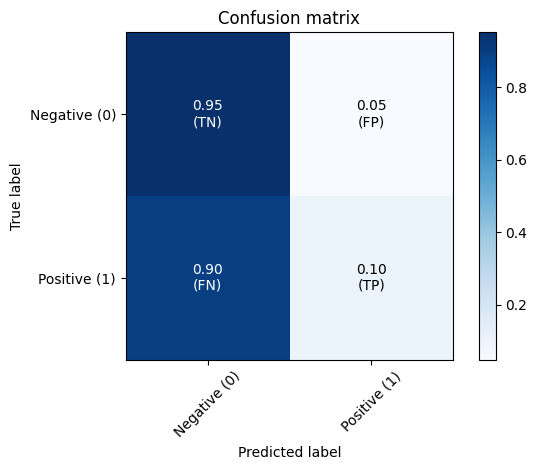

In [37]:
# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix \n{cnf_matrix}')
plot_confusion_matrix(cnf_matrix, classes=['Negative (0)', 'Positive (1)'])
plt.show()